# Estimating Obesity Levels Based on Eating Habits and Physical Activity  
**Capstone Project 2 by [Adi Kusuma] - [DataTalks.Club](https://datatalks.club)**  

Obesity is a growing global health issue. Understanding an individual's eating habits and physical activity levels can provide valuable insights into their overall health. Poor diet and lack of exercise are significant factors contributing to severe obesity, which can lead to serious health risks.  

In this project, I analyzed data from individuals in Colombia, Peru, and Mexico. The dataset, sourced from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition), includes 17 features and 2,111 records. Each record is labeled with the class variable `NObesity` (Obesity Level), which categorizes individuals into the following groups:  
- Insufficient Weight  
- Normal Weight  
- Overweight Level I  
- Overweight Level II  
- Obesity Type I  
- Obesity Type II  
- Obesity Type III  

Notably, **77% of the dataset was synthetically generated** using the Weka tool with the SMOTE filter, while **23% of the data was collected directly** from users via an online platform.  

This project aims to explore how eating habits and physical activity can help estimate obesity levels and provide actionable insights to improve health outcomes.

In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import os
import re
import numpy as np
import pandas as pd

In [2]:
import os
import requests
import zipfile

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.cm import inferno
from matplotlib.cm import plasma
#import mplcyberpunk

#plt.style.use("cyberpunk")

In [4]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
## Set Optuna logging level to WARNING to suppress logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore")

In [5]:
# Function to filter positive correlations
#def filter_positive_corr(df, threshold=0.5):
def filter_positive_corr(df, threshold):
    """
    Calculate the correlations between numerical columns in the DataFrame and
    display column pairs with positive correlations greater than the threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The positive correlation threshold (default: 0.5).

    Returns:
        pd.DataFrame: DataFrame containing column pairs with positive correlation > threshold.
    """
    # Select numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Create a DataFrame for column pairs with positive correlation > threshold
    corr_pairs = (
        corr_matrix
        .where(lambda x: x > threshold)  # Select positive correlations > threshold
        .stack()                         # Convert the matrix into column pairs
        .reset_index()                   # Reset index to create a DataFrame
        .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})
    )

    # Remove correlations between the same columns
    corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

    # Remove duplicate column pairs (Feature 1, Feature 2) and (Feature 2, Feature 1)
    corr_pairs['Ordered Pair'] = corr_pairs[['Feature 1', 'Feature 2']].apply(lambda x: tuple(sorted(x)), axis=1)
    corr_pairs = corr_pairs.drop_duplicates(subset='Ordered Pair').drop(columns='Ordered Pair')

    return corr_pairs.sort_values(by='Correlation', ascending=False)

# Function to filter negative correlations
#def filter_negative_corr(df, threshold=-0.5):
def filter_negative_corr(df, threshold):
    """
    Calculate the correlations between numerical columns in the DataFrame and
    display column pairs with negative correlations smaller than the threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The negative correlation threshold (default: -0.5).

    Returns:
        pd.DataFrame: DataFrame containing column pairs with negative correlation < threshold.
    """
    # Select numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Create a DataFrame for column pairs with negative correlation < threshold
    corr_pairs = (
        corr_matrix
        .where(lambda x: x < threshold)  # Select negative correlations < threshold
        .stack()                         # Convert the matrix into column pairs
        .reset_index()                   # Reset index to create a DataFrame
        .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})
    )

    # Remove correlations between the same columns
    corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

    # Remove duplicate column pairs (Feature 1, Feature 2) and (Feature 2, Feature 1)
    corr_pairs['Ordered Pair'] = corr_pairs[['Feature 1', 'Feature 2']].apply(lambda x: tuple(sorted(x)), axis=1)
    corr_pairs = corr_pairs.drop_duplicates(subset='Ordered Pair').drop(columns='Ordered Pair')

    return corr_pairs.sort_values(by='Correlation')

In [6]:
def positive_correlations(df, target_column, threshold):
    """
    Displays positive correlations greater than the threshold with the target_column, only for numeric columns
    and ignoring correlations with the column itself.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The target column to calculate correlations with.
        threshold (float): The minimum correlation threshold for positive correlations.

    Returns:
        pd.Series: Positive correlations greater than the threshold.
    """
    # Ensure the target column exists and is numeric
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[target_column]):
        raise TypeError(f"Column '{target_column}' must be numeric.")
    
    # Filter numeric columns and calculate correlations
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    correlations = numeric_df.corr()[target_column].sort_values(ascending=False)
    
    # Filter positive correlations greater than the threshold (excluding the column itself)
    return correlations[(correlations > threshold) & (correlations.index != target_column)]


In [7]:
def negative_correlations(df, target_column, threshold):
    """
    Displays negative correlations less than the threshold with the target_column, only for numeric columns
    and ignoring correlations with the column itself.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The target column to calculate correlations with.
        threshold (float): The maximum correlation threshold for negative correlations.

    Returns:
        pd.Series: Negative correlations less than the threshold.
    """
    # Ensure the target column exists and is numeric
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[target_column]):
        raise TypeError(f"Column '{target_column}' must be numeric.")
    
    # Filter numeric columns and calculate correlations
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    correlations = numeric_df.corr()[target_column].sort_values(ascending=True)
    
    # Filter negative correlations less than the threshold (excluding the column itself)
    return correlations[(correlations < threshold) & (correlations.index != target_column)]


In [8]:
def summarize_dataframe_20(df):
    """
    Membuat ringkasan informasi untuk DataFrame.
    
    Parameter:
        df (pd.DataFrame): DataFrame yang akan dirangkum.
    
    Returns:
        pd.DataFrame: DataFrame berisi ringkasan kolom, jumlah nilai unik, daftar nilai unik
                      (maksimum 20 nilai), jumlah NaN, persentase NaN, dan statistik value counts.
    """
    # Hitung jumlah nilai unik untuk setiap kolom
    nunique_values = df.nunique()

    # Buat daftar nilai unik (maksimum 20 nilai) untuk setiap kolom
    unique_values = [
        ', '.join(map(str, df[col].unique()[:20])) + ('...' if nunique_values[col] > 20 else '')
        for col in df.columns
    ]

    # Hitung jumlah nilai NaN untuk setiap kolom
    count_nan = df.isna().sum()

    # Hitung persentase nilai NaN untuk setiap kolom
    nan_percentage = (count_nan / len(df)) * 100
    
    # Ambil tipe data untuk setiap kolom
    dtype_values = df.dtypes

    # Hitung value_counts (maksimum 20 nilai) dan value_counts(normalize=True)
    value_counts_dict = {
        col: {k: v for k, v in list(df[col].value_counts().items())[:20]} for col in df.columns
    }
    value_counts_norm_dict = {
        col: {k: round(v, 3) for k, v in list(df[col].value_counts(normalize=True).items())[:20]} for col in df.columns
    }

    # Buat DataFrame ringkasan
    df_summary = pd.DataFrame({
        'columns': df.columns,
        'nunique': nunique_values.values,
        'unique (max 20)': unique_values,
        'len_value_counts': [len(df[col].value_counts()) for col in df.columns],  # Jumlah unique values per kolom
        'value_counts (max 20)': [value_counts_dict[col] for col in df.columns],
        'value_counts_norm (max 20)': [value_counts_norm_dict[col] for col in df.columns],
        'dtype': dtype_values.values,
        'count_nan': count_nan.values,
        'nan_percentage': nan_percentage.values,
    })
    
    return df_summary


In [9]:
def set_pandas_display_options():
    """
    Set pandas display options to show full text in columns, 
    display all columns, prevent line wrapping, and show all rows.
    """
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_rows', None)
    print("Pandas display options set all.")

def reset_pandas_display_options():
    """
    Reset pandas display options to their default values.
    """
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_rows')
    print("Pandas display options reset all to default.")


# Download dataset

In [10]:
# Define the URL of the CSV file
url = "https://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip"

In [11]:
# Check if the file already exists
if os.path.exists("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip"):
    print("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip already exists. Download canceled.")
else:
    # Download the file using requests (more secure and integrated)  
    response = requests.get(url)

    # Check for successful download
    if response.status_code == 200:
        # Write the data to a local ZIP file
        with open("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip", "wb") as f:
            f.write(response.content)
        print("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip downloaded successfully!")
    else:
        print(f"Error downloading file: {response.status_code}")

estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip already exists. Download canceled.


In [12]:
# Define the directory where the files will be extracted
extract_dir = "estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition"

# Check if the directory already exists
if not os.path.exists(extract_dir):
    # Unzip the file only if the directory doesn't exist
    with zipfile.ZipFile("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip", "r") as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"Files extracted to '{extract_dir}' directory.")
        print("Files extracted:", zip_ref.namelist())
else:
    print(f"Directory '{extract_dir}' already exists. Skipping extraction.")

Directory 'estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition' already exists. Skipping extraction.


# Feature description

| Variable Name                 | Role     | Type         | Demographic    | Description                                                                                 | Units | Missing Values |
|-------------------------------|----------|--------------|----------------|---------------------------------------------------------------------------------------------|-------|----------------|
| Gender                        | Feature  | Categorical  | Gender         |                                                                                             |       | no             |
| Age                           | Feature  | Continuous   | Age            |                                                                                             |       | no             |
| Height                        | Feature  | Continuous   |                |                                                                                             |       | no             |
| Weight                        | Feature  | Continuous   |                |                                                                                             |       | no             |
| family_history_with_overweight| Feature  | Binary       |                | Has a family member suffered or suffers from overweight?                                    |       | no             |
| FAVC                          | Feature  | Binary       |                | Do you eat high caloric food frequently?                                                   |       | no             |
| FCVC                          | Feature  | Integer      |                | Do you usually eat vegetables in your meals?                                               |       | no             |
| NCP                           | Feature  | Continuous   |                | How many main meals do you have daily?                                                     |       | no             |
| CAEC                          | Feature  | Categorical  |                | Do you eat any food between meals?                                                         |       | no             |
| SMOKE                         | Feature  | Binary       |                | Do you smoke?                                                                               |       | no             |
| CH2O                          | Feature  | Continuous   |                | How much water do you drink daily?                                                         |       | no             |
| SCC                           | Feature  | Binary       |                | Do you monitor the calories you eat daily?                                                 |       | no             |
| FAF                           | Feature  | Continuous   |                | How often do you have physical activity?                                                   |       | no             |
| TUE                           | Feature  | Integer      |                | How much time do you use technological devices such as cell phone, videogames, television, computer and others? |       | no             |
| CALC                          | Feature  | Categorical  |                | How often do you drink alcohol?                                                            |       | no             |
| MTRANS                        | Feature  | Categorical  |                | Which transportation do you usually use?                                                   |       | no             |
| NObeyesdad                    | Target   | Categorical  |                | Obesity level                                                                              |       | no             |


# Loading the dataset

In [13]:
df = pd.read_csv("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition/ObesityDataSet_raw_and_data_sinthetic.csv")
df.sample(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
296,Female,21.000000,1.530000,53.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1221,Female,22.596576,1.650052,87.272552,yes,yes,2.875990,1.291900,Sometimes,no,2.777712,no,0.432813,1.000000,no,Public_Transportation,Obesity_Type_I
1790,Male,23.147644,1.815514,120.337664,yes,yes,2.996717,2.791366,Sometimes,no,2.626309,no,1.194898,0.034897,Sometimes,Public_Transportation,Obesity_Type_II
412,Male,33.000000,1.850000,85.000000,no,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,0.000000,Sometimes,Automobile,Normal_Weight
542,Female,19.633898,1.660840,49.039794,no,no,2.750715,3.000000,Frequently,no,2.000000,no,1.067817,1.000000,Sometimes,Public_Transportation,Insufficient_Weight


# Exploratory data analysis (EDA)

## Renaming the columns

In [14]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [15]:
df.rename(columns={
    'family_history_with_overweight': 'Family_History_Overweight',
    'FAVC': 'High_Caloric_Food',
    'FCVC': 'Vegetable_Consumption',
    'NCP': 'Main_Meals_Per_Day',
    'CAEC': 'Snacking_Between_Meals',
    'SMOKE': 'Smoking',
    'CH2O': 'Water_Intake',
    'SCC': 'Calorie_Monitoring',
    'FAF': 'Physical_Activity_Frequency',
    'TUE': 'Tech_Usage_Hours',
    'CALC': 'Alcohol_Consumption',
    'MTRANS': 'Transportation_Mode',
    'NObeyesdad': 'Obesity_Level'
}, inplace=True)


In [16]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Family_History_Overweight',
       'High_Caloric_Food', 'Vegetable_Consumption', 'Main_Meals_Per_Day',
       'Snacking_Between_Meals', 'Smoking', 'Water_Intake',
       'Calorie_Monitoring', 'Physical_Activity_Frequency', 'Tech_Usage_Hours',
       'Alcohol_Consumption', 'Transportation_Mode', 'Obesity_Level'],
      dtype='object')

In [17]:
df.columns = df.columns.str.lower()


In [18]:
df.columns

Index(['gender', 'age', 'height', 'weight', 'family_history_overweight',
       'high_caloric_food', 'vegetable_consumption', 'main_meals_per_day',
       'snacking_between_meals', 'smoking', 'water_intake',
       'calorie_monitoring', 'physical_activity_frequency', 'tech_usage_hours',
       'alcohol_consumption', 'transportation_mode', 'obesity_level'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       2111 non-null   object 
 1   age                          2111 non-null   float64
 2   height                       2111 non-null   float64
 3   weight                       2111 non-null   float64
 4   family_history_overweight    2111 non-null   object 
 5   high_caloric_food            2111 non-null   object 
 6   vegetable_consumption        2111 non-null   float64
 7   main_meals_per_day           2111 non-null   float64
 8   snacking_between_meals       2111 non-null   object 
 9   smoking                      2111 non-null   object 
 10  water_intake                 2111 non-null   float64
 11  calorie_monitoring           2111 non-null   object 
 12  physical_activity_frequency  2111 non-null   float64
 13  tech_usage_hours  

## Dropping duplicated

In [20]:
df.duplicated().sum()

24

In [21]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Summary dataframe

In [22]:
set_pandas_display_options()

Pandas display options set all.


In [23]:
# Contoh penggunaan
df_summary = summarize_dataframe_20(df)
# Hapus baris dengan nilai 'ID' pada kolom 'columns'
#df_summary = df_summary[df_summary['columns'] != 'ID']
# Menyaring DataFrame agar kolom 'columns' tidak mengandung nilai tertentu
#df_summary = df_summary[~df_summary['columns'].isin(['efs_time', 'donor_age', 'age_at_hct'])]
# print(df_summary)
#df_summary

In [24]:
# Sort df_summary by the 'dtype' column in ascending order
df_summary = df_summary.sort_values(by='dtype', ascending=True)
df_summary

,columns,nunique,unique (max 20),len_value_counts,value_counts (max 20),value_counts_norm (max 20),dtype,count_nan,nan_percentage
1,age,1402,"21.0, 23.0, 27.0, 22.0, 29.0, 24.0, 26.0, 41.0, 30.0, 52.0, 20.0, 19.0, 31.0, 39.0, 17.0, 25.0, 55.0, 38.0, 18.0, 15.0...",1402,"{18.0: 126, 26.0: 101, 23.0: 89, 21.0: 78, 19.0: 59, 20.0: 48, 22.0: 37, 17.0: 30, 24.0: 18, 25.0: 15, 27.0: 14, 33.0: 13, 29.0: 11, 16.0: 8, 30.0: 8, 41.0: 7, 38.0: 7, 40.0: 6, 34.0: 5, 31.0: 4}","{18.0: 0.06, 26.0: 0.048, 23.0: 0.043, 21.0: 0.037, 19.0: 0.028, 20.0: 0.023, 22.0: 0.018, 17.0: 0.014, 24.0: 0.009, 25.0: 0.007, 27.0: 0.007, 33.0: 0.006, 29.0: 0.005, 16.0: 0.004, 30.0: 0.004, 41.0: 0.003, 38.0: 0.003, 40.0: 0.003, 34.0: 0.002, 31.0: 0.002}",float64,0,0.0
2,height,1574,"1.62, 1.52, 1.8, 1.78, 1.5, 1.64, 1.72, 1.85, 1.65, 1.77, 1.7, 1.93, 1.53, 1.71, 1.69, 1.6, 1.75, 1.68, 1.58, 1.79...",1574,"{1.7: 60, 1.65: 50, 1.6: 43, 1.75: 39, 1.8: 28, 1.62: 21, 1.72: 18, 1.63: 17, 1.67: 16, 1.78: 15, 1.56: 14, 1.74: 14, 1.55: 14, 1.66: 13, 1.68: 13, 1.76: 13, 1.85: 13, 1.5: 13, 1.64: 10, 1.69: 9}","{1.7: 0.029, 1.65: 0.024, 1.6: 0.021, 1.75: 0.019, 1.8: 0.013, 1.62: 0.01, 1.72: 0.009, 1.63: 0.008, 1.67: 0.008, 1.78: 0.007, 1.56: 0.007, 1.74: 0.007, 1.55: 0.007, 1.66: 0.006, 1.68: 0.006, 1.76: 0.006, 1.85: 0.006, 1.5: 0.006, 1.64: 0.005, 1.69: 0.004}",float64,0,0.0
3,weight,1525,"64.0, 56.0, 77.0, 87.0, 89.8, 53.0, 55.0, 68.0, 105.0, 80.0, 99.0, 60.0, 66.0, 102.0, 78.0, 82.0, 70.0, 50.0, 65.0, 52.0...",1525,"{80.0: 59, 50.0: 42, 75.0: 39, 60.0: 37, 70.0: 29, 65.0: 25, 90.0: 20, 78.0: 19, 45.0: 18, 85.0: 18, 42.0: 18, 82.0: 17, 56.0: 15, 58.0: 14, 68.0: 14, 55.0: 14, 53.0: 13, 62.0: 11, 83.0: 10, 72.0: 10}","{80.0: 0.028, 50.0: 0.02, 75.0: 0.019, 60.0: 0.018, 70.0: 0.014, 65.0: 0.012, 90.0: 0.01, 78.0: 0.009, 45.0: 0.009, 85.0: 0.009, 42.0: 0.009, 82.0: 0.008, 56.0: 0.007, 58.0: 0.007, 68.0: 0.007, 55.0: 0.007, 53.0: 0.006, 62.0: 0.005, 83.0: 0.005, 72.0: 0.005}",float64,0,0.0
13,tech_usage_hours,1129,"1.0, 0.0, 2.0, 0.29499, 0.838957, 0.479221, 0.62535, 0.26579, 0.555468, 0.928972, 1.340107, 0.58998, 1.37465, 1.283673, 0.062488, 0.9974, 0.738269, 0.860497, 0.478676, 0.555967...",1129,"{0.0: 537, 1.0: 289, 2.0: 108, 0.630866: 4, 1.119877: 3, 0.0026: 3, 0.009254: 2, 0.8324: 2, 1.36595: 2, 0.828549: 2, 1.59257: 2, 0.369134: 2, 1.875023: 2, 0.469735: 2, 0.677909: 2, 0.105895: 2, 1.339232: 2, 0.37465: 2, 1.415536: 2, 0.371941: 2}","{0.0: 0.257, 1.0: 0.138, 2.0: 0.052, 0.630866: 0.002, 1.119877: 0.001, 0.0026: 0.001, 0.009254: 0.001, 0.8324: 0.001, 1.36595: 0.001, 0.828549: 0.001, 1.59257: 0.001, 0.369134: 0.001, 1.875023: 0.001, 0.469735: 0.001, 0.677909: 0.001, 0.105895: 0.001, 1.339232: 0.001, 0.37465: 0.001, 1.415536: 0.001, 0.371941: 0.001}",float64,0,0.0
6,vegetable_consumption,810,"2.0, 3.0, 1.0, 2.450218, 2.880161, 2.00876, 2.596579, 2.591439, 2.392665, 1.123939, 2.027574, 2.658112, 2.88626, 2.714447, 2.750715, 1.4925, 2.205439, 2.059138, 2.310423, 2.823179...",810,"{3.0: 647, 2.0: 581, 1.0: 33, 2.823179: 2, 2.21498: 2, 2.795086: 2, 2.442536: 2, 2.81646: 2, 2.938031: 2, 2.954996: 2, 2.903545: 2, 2.39728: 2, 2.204914: 2, 2.758394: 2, 2.971574: 2, 2.568063: 2, 2.407817: 2, 2.392665: 2, 2.13683: 2, 2.630137: 2}","{3.0: 0.31, 2.0: 0.278, 1.0: 0.016, 2.823179: 0.001, 2.21498: 0.001, 2.795086: 0.001, 2.442536: 0.001, 2.81646: 0.001, 2.938031: 0.001, 2.954996: 0.001, 2.903545: 0.001, 2.39728: 0.001, 2.204914: 0.001, 2.758394: 0.001, 2.971574: 0.001, 2.568063: 0.001, 2.407817: 0.001, 2.392665: 0.001, 2.13683: 0.001, 2.630137: 0.001}",float64,0,0.0
7,main_meals_per_day,635,"3.0, 1.0, 4.0, 3.28926, 3.995147, 1.72626, 2.581015, 1.600812, 1.73762, 1.10548, 2.0846, 1.894384, 2.857787, 3.765526, 3.285167, 3.691226, 3.156153, 1.07976, 3.559841, 3.891994...",635,"{3.0: 1199, 1.0: 179, 4.0: 69, 2.77684: 2, 3.985442: 2, 1.73762: 2, 1.894384: 2, 1.104642: 2, 2.644692: 2, 3.559841: 2, 3.691226: 2, 2.988539: 1, 1.508685: 1, 2.209314: 1, 1.114564: 1, 2.036794: 1, 2.733077: 1, 1.63

In [25]:
reset_pandas_display_options()

Pandas display options reset all to default.


## Data visualization

### Balance of the target variable

In [26]:
df['obesity_level'].value_counts()

obesity_level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

In [27]:
obesity_counts = df['obesity_level'].value_counts()


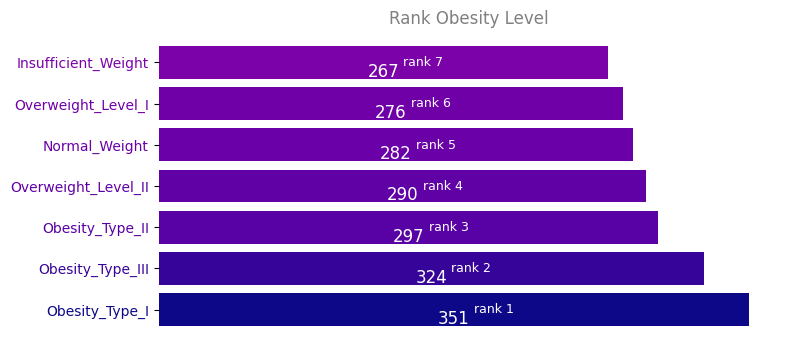

In [28]:
# Use the 'viridis' color palette with reversed colors
#colors = viridis(1 - obesity_counts / max(obesity_counts))
colors = plasma(1 - obesity_counts / max(obesity_counts))

# Create a horizontal bar chart
plt.figure(figsize=(8, 4))
bars = plt.barh(obesity_counts.index, obesity_counts, color=colors)

# Add value and rank inside each bar
for bar, count, color, street_name in zip(bars, obesity_counts, colors, obesity_counts.index):
    xval = bar.get_width()
    rank = obesity_counts.index.get_loc(street_name) + 1
    
    # Add value inside each bar
    plt.text(xval / 2, bar.get_y() + bar.get_height() / 2, f'{count}', ha='center', va='top', color='white', fontsize=12, fontweight=200)

    # Add rank text to the right of each bar
    plt.text(xval / 2 + 12, bar.get_y() + bar.get_height() / 2, f'rank {rank}', ha='left', va='center', color='white', fontsize=9, fontweight=200)

    # Set text color on the y-axis the same as the bar color
    plt.gca().yaxis.get_ticklabels()[list(obesity_counts.index).index(street_name)].set_color(color)

# Remove spines on the x and y axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove x-axis labels
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Add title
plt.title('Rank Obesity Level', color='gray')

# Show the horizontal bar chart
plt.show()


### The relationship in dataframe

In [29]:
# Pisahkan kolom numerik dan kategorikal
numerical_columns = df.select_dtypes(include=['number'])
categorical_columns = df.select_dtypes(exclude=['number'])

# One-hot encoding untuk kolom kategorikal
categorical_columns = pd.get_dummies(categorical_columns, drop_first=True)

# Gabungkan kembali kolom numerik dan kategorikal
all_columns_corr = pd.concat([numerical_columns, categorical_columns], axis=1)

# Konversi kolom boolean menjadi integer
for column in all_columns_corr.select_dtypes(include=['bool']).columns:
    all_columns_corr[column] = all_columns_corr[column].astype(int)


In [30]:
# Contoh penggunaan:
positive_corr_df = filter_positive_corr(all_columns_corr, threshold=0.2)
positive_corr_df


,Feature 1,Feature 2,Correlation
8,height,gender_Male,0.626748
20,weight,obesity_level_Obesity_Type_III,0.557996
15,weight,family_history_overweight_yes,0.492969
23,vegetable_consumption,obesity_level_Obesity_Type_III,0.463916
4,height,weight,0.457468
19,weight,obesity_level_Obesity_Type_II,0.442523
17,weight,snacking_between_meals_Sometimes,0.406347
34,gender_Male,obesity_level_Obesity_Type_II,0.398544
40,family_history_overweight_yes,snacking_between_meals_Sometimes,0.316112
57,alcohol_consumption_Sometimes,obesity_level_Obesity_Type_III,0.304048


In [31]:
negative_corr_df = filter_negative_corr(all_columns_corr, threshold=-0.2)
negative_corr_df

,Feature 1,Feature 2,Correlation
22,alcohol_consumption_Sometimes,alcohol_consumption_no,-0.924964
14,snacking_between_meals_Frequently,snacking_between_meals_Sometimes,-0.829896
1,age,transportation_mode_Public_Transportation,-0.555532
9,gender_Male,obesity_level_Obesity_Type_III,-0.429553
2,weight,snacking_between_meals_Frequently,-0.378262
5,weight,obesity_level_Normal_Weight,-0.372760
17,snacking_between_meals_Sometimes,obesity_level_Normal_Weight,-0.316388
16,snacking_between_meals_Sometimes,snacking_between_meals_no,-0.312245
0,age,tech_usage_hours,-0.302927
11,family_history_overweight_yes,obesity_level_Normal_Weight,-0.297690


### The relationship with `obesity_level_Obesity_Type_I`

In [32]:
# Set the threshold for positive correlations
threshold = 0.05

# Find positive correlations with the specified threshold
positive_corrs1 = positive_correlations(all_columns_corr, 'obesity_level_Obesity_Type_I', threshold)
print(f"\nPositive correlations greater than {threshold}:\n", positive_corrs1)


Positive correlations greater than 0.05:
 family_history_overweight_yes       0.183412
alcohol_consumption_no              0.161518
snacking_between_meals_Sometimes    0.147595
high_caloric_food_yes               0.119296
age                                 0.108179
weight                              0.103232
water_intake                        0.079462
Name: obesity_level_Obesity_Type_I, dtype: float64


In [33]:
# Set the threshold for negative correlations
threshold = -0.05

# Find negative correlations with the specified threshold
negative_corrs1 = negative_correlations(all_columns_corr, 'obesity_level_Obesity_Type_I', threshold)
print(f"Negative correlations less than {threshold}:\n", negative_corrs1)

Negative correlations less than -0.05:
 vegetable_consumption                       -0.198006
obesity_level_Obesity_Type_III              -0.192764
obesity_level_Obesity_Type_II               -0.183160
obesity_level_Overweight_Level_II           -0.180636
obesity_level_Normal_Weight                 -0.177732
obesity_level_Overweight_Level_I            -0.175539
alcohol_consumption_Sometimes               -0.162658
main_meals_per_day                          -0.158418
snacking_between_meals_Frequently           -0.136287
calorie_monitoring_yes                      -0.086506
transportation_mode_Public_Transportation   -0.076660
transportation_mode_Walking                 -0.057982
snacking_between_meals_no                   -0.050701
Name: obesity_level_Obesity_Type_I, dtype: float64


# Splitting the dataset

## Setting seeds for reproducibility

In [34]:
import random
import os
#import keras

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Setting the validation framework

In [35]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.15, random_state=seed_value, stratify=df["obesity_level"])
df_train, df_val = train_test_split(df_full_train, test_size=0.15, random_state=seed_value, stratify=df_full_train["obesity_level"])
len(df_train), len(df_test), len(df_val)

(1507, 314, 266)

## Removing specific columns and separating features from the target column

According to [the dataset's article](https://doi.org/10.1016/j.dib.2019.104344), the data was labeled using the following equation:

$Mass\ body\ index = \frac{weight}{{height}^2}$

Therefore, we need to delete at least a feature into previous equation.

cols_drop = ["obesity_level", "weight"]
X_full_train, y_full_train = df_full_train.drop(cols_drop, axis=1), df_full_train["obesity_level"]
X_train, y_train =  df_train.drop(cols_drop, axis=1), df_train["obesity_level"]
X_val, y_val =  df_val.drop(cols_drop, axis=1), df_val["obesity_level"]
X_test, y_test =  df_test.drop(cols_drop, axis=1), df_test["obesity_level"]

In [36]:
#cols_drop = ["obesity_level", "weight"]
cols_drop = ["obesity_level"]
X_full_train, y_full_train = df_full_train.drop(cols_drop, axis=1), df_full_train["obesity_level"]
X_train, y_train =  df_train.drop(cols_drop, axis=1), df_train["obesity_level"]
X_val, y_val =  df_val.drop(cols_drop, axis=1), df_val["obesity_level"]
X_test, y_test =  df_test.drop(cols_drop, axis=1), df_test["obesity_level"]

# Standardization

In [37]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(exclude=["object"]).columns

ss = StandardScaler().set_output(transform="pandas")

ss.fit(X_train[numeric_cols])
ss.transform(X_train[numeric_cols])

,age,height,weight,vegetable_consumption,main_meals_per_day,water_intake,physical_activity_frequency,tech_usage_hours
2071,-0.859706,0.482798,1.583541,1.091725,0.378982,0.667080,-0.024754,0.010910
190,-0.679409,-1.084919,-1.165974,-0.803418,0.378982,-0.005343,-0.007330,-1.100719
1361,-0.996350,-0.153529,0.119958,0.593585,0.378982,-0.009926,0.410323,-0.329281
2109,0.011829,0.409630,1.759045,1.091725,0.378982,1.387169,0.157412,-0.135712
325,-0.520938,-1.620791,-1.090340,-0.803418,-2.235837,-1.639098,-0.007330,-1.100719
...,...,...,...,...,...,...,...,...
1357,-0.996350,0.891401,0.816134,-0.803418,-0.306828,1.066065,-0.007330,-0.820984
1013,4.906080,0.729214,-0.239784,-0.803418,0.378982,-0.005343,-0.007330,-1.100719
1971,-0.790813,1.243673,2.083181,1.091725,0.378982,1.137754,0.609467,0.157322
1265,-1.048027,0.399074,0.391538,-0.803418,0.378982,-0.005343,-1.191614,-0.716527


# One-hot encoding of features

In [38]:
from sklearn.feature_extraction import DictVectorizer

dict_X_full_train = X_full_train.to_dict("records")
dict_X_train = X_train.to_dict("records")
dict_X_val = X_val.to_dict("records")
dict_X_test = X_test.to_dict("records")

dv = DictVectorizer(sparse=False).set_output(transform="pandas")
dv.fit(dict_X_train)

dv.transform(dict_X_train).head()

,age,alcohol_consumption=Always,alcohol_consumption=Frequently,alcohol_consumption=Sometimes,alcohol_consumption=no,calorie_monitoring=no,calorie_monitoring=yes,family_history_overweight=no,family_history_overweight=yes,gender=Female,...,snacking_between_meals=no,tech_usage_hours,transportation_mode=Automobile,transportation_mode=Bike,transportation_mode=Motorbike,transportation_mode=Public_Transportation,transportation_mode=Walking,vegetable_consumption,water_intake,weight
0,18.862264,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.675076,0.0,0.0,0.0,1.0,0.0,3.000000,2.411582,128.705761
1,20.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,2.000000,2.000000,56.000000
2,18.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.468483,0.0,0.0,0.0,1.0,0.0,2.737149,1.997195,90.004046
3,24.361936,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.586035,0.0,0.0,0.0,1.0,0.0,3.000000,2.852339,133.346641
4,21.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,2.000000,1.000000,58.000000


# Creating a Pipeline

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.ss = StandardScaler().set_output(transform="pandas")
        self.numeric_cols = numeric_cols
        return

    def fit(self, X):
        self.ss.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X[self.numeric_cols] = self.ss.transform(X[self.numeric_cols])
        return X.to_dict("records")

numeric_cols = X_train.select_dtypes(exclude=["object"]).columns
pipe = Pipeline([('ss', MyStandardScaler(numeric_cols=numeric_cols)), ('dv', DictVectorizer(sparse=False).set_output(transform="pandas"))])

X_train = pipe.fit_transform(X_train)
X_full_train = pipe.transform(X_full_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

# Label encoding

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_full_train = le.transform(y_full_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Computing weigths for classes and samples

In [41]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

class_full_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_full_train), y=y_full_train)
class_full_weight = dict(zip(np.unique(y_full_train), class_full_weight))

class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), class_weight))

sample_full_weights = compute_sample_weight(
    class_weight=class_full_weight,
    y=y_full_train
)

sample_weights = compute_sample_weight(
    class_weight=class_weight,
    y=y_train
)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

# Training the models

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [44]:
# Daftar model yang akan digunakan
models = {
    #"Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train))),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True, decision_function_shape='ovr'),
    "Naive Bayes": GaussianNB(),
    "Ridge Classifier": RidgeClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),  # CatBoost secara otomatis menangani multi-class
    #"LightGBM": LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train)), 
    #                           early_stopping_rounds=10)  # Stop after 10 rounds of no improvement
    "LightGBM": LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train)))  # LightGBM multi-class
}

# Fungsi untuk melatih model dan menghitung skor
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    
    # Evaluasi metrik
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='weighted')
    recall = recall_score(y_val, predictions, average='weighted')
    f1 = f1_score(y_val, predictions, average='weighted')
    
    # ROC AUC untuk multi-class
    try:
        roc_auc = roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr', average='weighted')
    except Exception as e:
        roc_auc = 'N/A'
    
    return accuracy, precision, recall, f1, roc_auc



In [45]:
# Mengumpulkan hasil evaluasi model
results = {}

# Evaluasi setiap model
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, roc_auc = train_and_evaluate_model(model, X_train, y_train, X_val, y_val)
        results[name] = (accuracy, precision, recall, f1, roc_auc)
        print(f"{name} - Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}, ROC AUC: {roc_auc}")
    except Exception as e:
        print(f"Error in {name}: {e}")



Decision Tree - Accuracy: 0.91729, Precision: 0.91905, Recall: 0.91729, F1: 0.91721, ROC AUC: 0.9519572964055308
Random Forest - Accuracy: 0.90977, Precision: 0.91862, Recall: 0.90977, F1: 0.91096, ROC AUC: 0.9886171006596998
XGBoost - Accuracy: 0.96992, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, ROC AUC: 0.9977756591612065
Gradient Boosting - Accuracy: 0.95113, Precision: 0.95464, Recall: 0.95113, F1: 0.95197, ROC AUC: 0.997675121354274
AdaBoost - Accuracy: 0.43609, Precision: 0.28704, Recall: 0.43609, F1: 0.32386, ROC AUC: 0.8453109588103523


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K-Neighbors - Accuracy: 0.85338, Precision: 0.84547, Recall: 0.85338, F1: 0.83956, ROC AUC: 0.9552697692973877
Support Vector Machine - Accuracy: 0.89474, Precision: 0.89656, Recall: 0.89474, F1: 0.89550, ROC AUC: 0.9916384357911708
Naive Bayes - Accuracy: 0.56391, Precision: 0.60190, Recall: 0.56391, F1: 0.51407, ROC AUC: 0.8808866956796562
Ridge Classifier - Accuracy: 0.65414, Precision: 0.64183, Recall: 0.65414, F1: 0.63059, ROC AUC: N/A
Extra Trees - Accuracy: 0.87218, Precision: 0.87882, Recall: 0.87218, F1: 0.87376, ROC AUC: 0.9847932003479052
CatBoost - Accuracy: 0.95113, Precision: 0.95485, Recall: 0.95113, F1: 0.95191, ROC AUC: 0.9977131072717782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 1507, number of us

In [49]:
# Mengurutkan model berdasarkan accuracy
sorted_results_accuracy = sorted(results.items(), key=lambda x: x[1][0], reverse=True)

# Menampilkan 3 model terbaik berdasarkan accuracy
print("\nTop 3 Models in Accuracy:")
for i in range(3):
    name, metrics = sorted_results_accuracy[i]
    print(f"{i+1}. {name} - Accuracy: {metrics[0]:.5f}, Precision: {metrics[1]:.5f}, Recall: {metrics[2]:.5f}, F1: {metrics[3]:.5f}, ROC AUC: {metrics[4]:.5f}")

# Memfilter hasil dengan ROC AUC yang valid (numerik)
valid_results_roc_auc = {name: metrics for name, metrics in results.items() if isinstance(metrics[4], (int, float))}

# Mengurutkan model berdasarkan ROC AUC
sorted_results_roc_auc = sorted(valid_results_roc_auc.items(), key=lambda x: x[1][4], reverse=True)

# Menampilkan 3 model terbaik berdasarkan ROC AUC
print("\nTop 3 Models in ROC AUC:")
for i in range(3):
    name, metrics = sorted_results_roc_auc[i]
    print(f"{i+1}. {name} - ROC AUC: {metrics[4]:.5f}, Precision: {metrics[1]:.5f}, Recall: {metrics[2]:.5f}, F1: {metrics[3]:.5f}, Accuracy: {metrics[0]:.5f}")



Top 3 Models in Accuracy:
1. XGBoost - Accuracy: 0.96992, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, ROC AUC: 0.99778
2. LightGBM - Accuracy: 0.96617, Precision: 0.96845, Recall: 0.96617, F1: 0.96649, ROC AUC: 0.99851
3. Gradient Boosting - Accuracy: 0.95113, Precision: 0.95464, Recall: 0.95113, F1: 0.95197, ROC AUC: 0.99768

Top 3 Models in ROC AUC:
1. LightGBM - ROC AUC: 0.99851, Precision: 0.96845, Recall: 0.96617, F1: 0.96649, Accuracy: 0.96617
2. XGBoost - ROC AUC: 0.99778, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, Accuracy: 0.96992
3. CatBoost - ROC AUC: 0.99771, Precision: 0.95485, Recall: 0.95113, F1: 0.95191, Accuracy: 0.95113


In [55]:
#import os
#import random
#import numpy as np
import optuna
from sklearn.metrics import log_loss

#from catboost import CatBoostClassifier
#from sklearn.metrics import accuracy_score

# Set random seed
#seed_value = 42
#os.environ['PYTHONHASHSEED'] = str(seed_value)
#random.seed(seed_value)
#np.random.seed(seed_value)



In [57]:
# Objective function for CatBoostClassifier (Multiclass)
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'MultiClass',  # Menggunakan MultiClass untuk klasifikasi multikelas
        'random_state': 42
    }

    # Create a CatBoostClassifier model with the specified parameters
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)

    # Predict on the validation data
    y_pred_proba = model.predict_proba(X_val)  # Get probabilities for all classes

    # Calculate the log loss or any other appropriate evaluation metric for multiclass
    log_loss_value = log_loss(y_val, y_pred_proba)
    return log_loss_value

# Create study with TPESampler and fixed seed
study_catboost = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed here
)

# Run Optuna for CatBoostClassifier
study_catboost.optimize(objective_catboost, n_trials=50)

# Best results for CatBoostClassifier
print("Best parameters for CatBoostClassifier:")
print(study_catboost.best_trial.params)
print("Best Log Loss for CatBoostClassifier: {:.5f}".format(study_catboost.best_value))


[I 2025-01-25 15:17:57,053] A new study created in memory with name: no-name-18f85f1c-7c2c-4598-bdb4-83c9e7bfeffa
[I 2025-01-25 15:18:19,317] Trial 0 finished with value: 0.22837977119582234 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.22, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.004207988669606638, 'bagging_temperature': 0.15599452033620265, 'border_count': 15}. Best is trial 0 with value: 0.22837977119582234.
[I 2025-01-25 15:18:33,951] Trial 1 finished with value: 0.20704691268198627 and parameters: {'iterations': 880, 'depth': 8, 'learning_rate': 0.22, 'l2_leaf_reg': 0.0012087541473056963, 'random_strength': 7.579479953348009, 'bagging_temperature': 0.8324426408004217, 'border_count': 55}. Best is trial 1 with value: 0.20704691268198627.
[I 2025-01-25 15:18:35,027] Trial 2 finished with value: 0.11402490455908634 and parameters: {'iterations': 263, 'depth': 5, 'learning_rate': 0.09999999999999999, 'l2_leaf_reg': 0.12561043700013558, 'random_st

Best parameters for CatBoostClassifier:
{'iterations': 434, 'depth': 4, 'learning_rate': 0.15000000000000002, 'l2_leaf_reg': 0.002473403654859812, 'random_strength': 0.006477967147195818, 'bagging_temperature': 0.7573147661433607, 'border_count': 220}
Best Log Loss for CatBoostClassifier: 0.08668


## Logistic Regression

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



In [ ]:
parameters = {"max_iter":[200, 300, 400, 500],
              "C":[20, 15, 10],
              "class_weight":["balanced"],
              "solver":["lbfgs", "newton-cg", "sag", "saga"]}

lr = LogisticRegression(random_state=seed_value)
gs_lr = GridSearchCV(lr, param_grid=parameters, n_jobs=-1, cv=5, scoring="roc_auc_ovr")
gs_lr.fit(X_full_train, y_full_train, sample_weight=sample_full_weights)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [20, 15, 10], 'class_weight': ['balanced'],
                         'max_iter': [200, 300, 400, 500],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             scoring='roc_auc_ovr')

In [ ]:
y_pred_test_lr = gs_lr.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test_lr, multi_class="ovr")

0.889393203661662

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
parameters = {"criterion":["gini", "entropy", "log_loss"],
              "max_depth":[5, 6, 7, 8, 9],
              "max_leaf_nodes":[30, 40, 50, 60],
              "min_samples_split":[30, 40],
              "class_weight":["balanced"],}

dt = DecisionTreeClassifier(random_state=seed_value)
gs_dt = GridSearchCV(dt, param_grid=parameters, n_jobs=-1, cv=5, scoring="roc_auc_ovr")
gs_dt.fit(X_full_train, y_full_train, sample_weight=sample_full_weights)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_leaf_nodes': [30, 40, 50, 60],
                         'min_samples_split': [30, 40]},
             scoring='roc_auc_ovr')

In [ ]:
y_pred_test_dt = gs_dt.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test_dt, multi_class="ovr")

0.9213027545513881

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters = {"criterion":["gini", "entropy", "log_loss"],
              "n_estimators":[100, 200, 300, 400],
              "max_depth":[5, 6, 7, 8, 9],
              "class_weight":["balanced"],}

rf = RandomForestClassifier(random_state=seed_value)
gs_rf = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, cv=5, scoring="roc_auc_ovr")
gs_rf.fit(X_full_train, y_full_train, sample_weight=sample_full_weights)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='roc_auc_ovr')

In [ ]:
y_pred_test_rf = gs_rf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_test_rf, multi_class="ovr")

0.9721096055019289

## Gradient Boosting with XGBoost

In [55]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns.tolist())

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'gamma':0.0001,
    'min_child_weight': 1,
    'alpha':0.01,

    'objective': 'multi:softprob',
    'num_class':7,
    'nthread': 8,
    'eval_metric':'auc',
    'num_parallel_tree':5,

    'seed':seed_value,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_clf = xgb.train(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=100, evals=watchlist, verbose_eval=200)
y_test_pred_xgb = xgb_clf.predict(dtest)
print(f"ROC:{roc_auc_score(y_test, y_test_pred_xgb, multi_class='ovr')}")

[0]	train-auc:0.96308	val-auc:0.88976
[200]	train-auc:1.00000	val-auc:0.97088
[400]	train-auc:1.00000	val-auc:0.97176
[600]	train-auc:1.00000	val-auc:0.97269
[800]	train-auc:1.00000	val-auc:0.97309
[942]	train-auc:1.00000	val-auc:0.97303
ROC:0.9806772041514711


## Gradient Boosting with CatBoost

According to [this blog](https://aravindkolli.medium.com/understanding-catboost-the-gradient-boosting-algorithm-for-categorical-data-73ddb200895d).

CatBoost operates on the principle of gradient boosting, where it builds the model in a stage-wise fashion. It starts with a simple model and incrementally improves it by adding new models that correct the errors made by the preceding ones.

CatBoost introduces several key innovations:

### Ordered Boosting
One of the core innovations of CatBoost is its ordered boosting mechanism. Traditional gradient boosting methods can suffer from prediction shift due to the overlap between the training data for the base models and the data used to calculate the gradients. CatBoost addresses this by introducing a random permutation of the dataset in each iteration and using only the data before each example in the permutation for training. This approach reduces overfitting and improves model robustness.

### Symmetric Trees

CatBoost builds balanced trees, also known as symmetric trees, as its base predictors. Unlike traditional gradient boosting methods that build trees leaf-wise or depth-wise, CatBoost’s symmetric trees ensure that all leaf nodes at the same level share the same decision rule. This leads to faster execution and reduces the likelihood of overfitting.

In [53]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(loss_function='MultiClass',
                         eval_metric='AUC',
                         iterations=5000,
                         depth=6,
                         classes_count=7,
                         class_weights=class_weight,
                         learning_rate=0.1,
                         od_type='Iter',
                         early_stopping_rounds=1000,
                         bootstrap_type='MVS',
                         sampling_frequency='PerTree',
                         random_seed=seed_value,
                         verbose=200)
cbc.fit(X_train, y_train, sample_weight=sample_weights, eval_set=(X_val, y_val))

y_test_pred_cbc = cbc.predict_proba(X_test)
print(f"ROC:{roc_auc_score(y_test, y_test_pred_cbc, multi_class='ovr')}")

0:	test: 0.8701799	best: 0.8701799 (0)	total: 36.5ms	remaining: 6m 5s
200:	test: 0.9843814	best: 0.9843814 (200)	total: 6.27s	remaining: 5m 5s
400:	test: 0.9859230	best: 0.9860489 (384)	total: 9.02s	remaining: 3m 35s
600:	test: 0.9859990	best: 0.9862174 (434)	total: 11.7s	remaining: 3m 2s
800:	test: 0.9860843	best: 0.9865136 (706)	total: 14.4s	remaining: 2m 45s
1000:	test: 0.9861372	best: 0.9865136 (706)	total: 19s	remaining: 2m 51s
1200:	test: 0.9859280	best: 0.9865136 (706)	total: 21.9s	remaining: 2m 40s
1400:	test: 0.9860076	best: 0.9865136 (706)	total: 24.5s	remaining: 2m 30s
1600:	test: 0.9857638	best: 0.9865136 (706)	total: 27.2s	remaining: 2m 22s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9865136358
bestIteration = 706

Shrink model to first 707 iterations.
ROC:0.9849353946292636


## Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [ ]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(seed_value)

autotune = tf.data.AUTOTUNE

batch_size = 32

train_data = Dataset.from_tensor_slices((X_train.astype(float), y_train.astype(float))).batch(batch_size, num_parallel_calls=autotune).prefetch(autotune)
val_data = Dataset.from_tensor_slices((X_val.astype(float), y_val.astype(float))).batch(batch_size, num_parallel_calls=autotune).prefetch(autotune)
test_data = Dataset.from_tensor_slices((X_test.astype(float), y_test.astype(float))).batch(batch_size).prefetch(autotune)

early = EarlyStopping(monitor='val_loss', patience=10)

inp = Input(shape=(30, ))
x = Dense(256, activation='relu')(inp)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

nn = Model(inputs=inp, outputs=x)
nn.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adamax(learning_rate=0.5e-2), metrics=[SparseCategoricalAccuracy()])
nn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,759 (292.03 KB)

 Trainable params: 74,759 (292.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 1000
history = nn.fit(train_data,
                epochs=epochs,
                verbose=1,
                validation_data=val_data,
                class_weight=class_weight,
                callbacks=[early]
                )

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.8327 - sparse_categorical_accuracy: 0.2595 - val_loss: 1.2738 - val_sparse_categorical_accuracy: 0.4511
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3165 - sparse_categorical_accuracy: 0.4592 - val_loss: 1.0407 - val_sparse_categorical_accuracy: 0.6617
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1631 - sparse_categorical_accuracy: 0.5468 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.6692
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0944 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.9358 - val_sparse_categorical_accuracy: 0.6654
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9901 - sparse_categorical_accuracy: 0.6048 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.6617
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9382 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.8158 - val_sparse_categorical_accuracy: 0.6992
Epoc

In [ ]:
y_pred_test_nn = nn.predict(test_data, batch_size=batch_size)

roc_auc_score(y_test, y_pred_test_nn, multi_class='ovr')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


0.9612609703428328

## Comparison of models

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def get_scores(y_true, y_pred, y_pred_proba):
    return {'AUC_ROC':roc_auc_score(y_true, y_pred_proba, multi_class='ovr'),
           'F1_Score':f1_score(y_true, y_pred, average='weighted'),
           'Accuracy':accuracy_score(y_true, y_pred),
           'Precision':precision_score(y_true, y_pred, average='weighted'),
           'Recall':recall_score(y_true, y_pred, average='weighted')}
scores = []
for model in [gs_lr, gs_dt, gs_rf, xgb_clf, cbc, nn]:
    if model == xgb_clf:
        y_test_pred = np.argmax(model.predict(dtest), axis=1)
        y_test_pred_proba = model.predict(dtest)
    elif model == nn:
        y_test_pred = np.argmax(model.predict(test_data), axis=1)
        y_test_pred_proba = model.predict(test_data)
    else:
        y_test_pred = model.predict(X_test)
        y_test_pred_proba = model.predict_proba(X_test)
    scores.append(get_scores(y_test, y_test_pred, y_test_pred_proba).values())

comparison = pd.DataFrame(data=scores, index=["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "CatBoost", "Neural Network"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,AUC_ROC,F1_Score,Accuracy,Precision,Recall
Logistic Regression,0.889393,0.621080,0.636943,0.631468,0.636943
Decision Tree,0.921303,0.682760,0.681529,0.691372,0.681529
Random Forest,0.972110,0.838787,0.840764,0.842998,0.840764
XGBoost,0.980677,0.866181,0.866242,0.867547,0.866242
CatBoost,0.984935,0.891044,0.891720,0.891502,0.891720
Neural Network,0.961261,0.831495,0.831210,0.835182,0.831210


## Confusion matrix

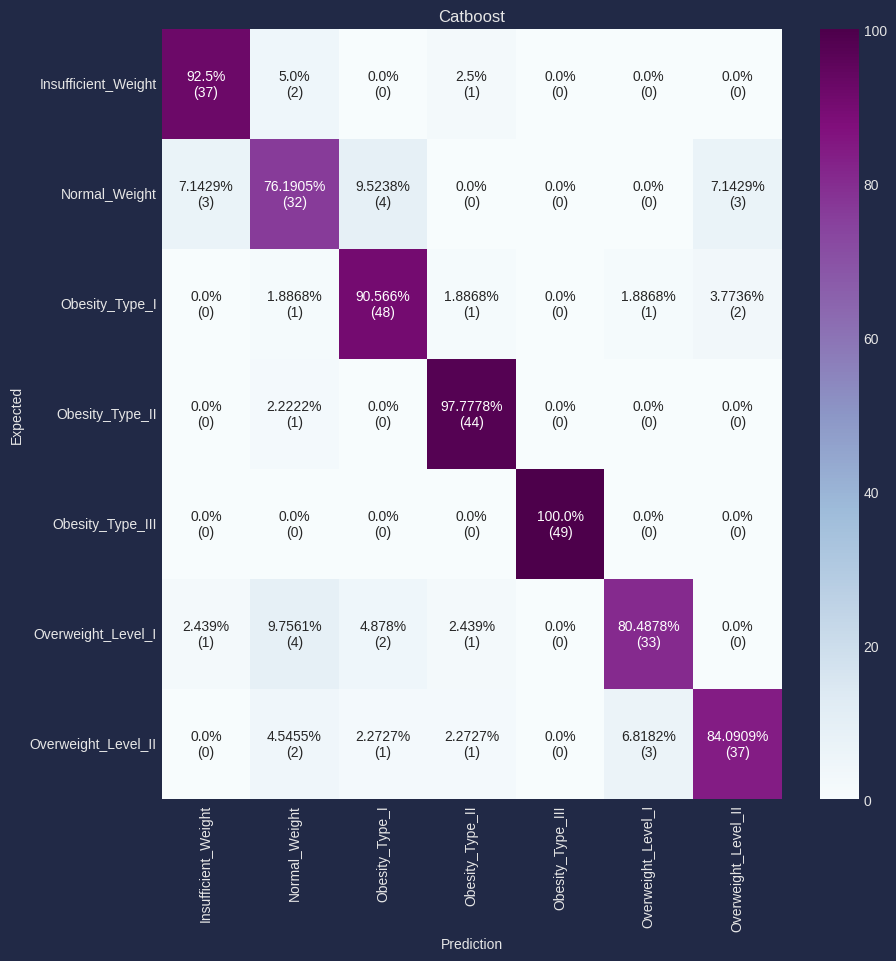

In [ ]:
from sklearn.metrics import confusion_matrix

def my_cm(y_true, y_pred, title):
    cm_val = confusion_matrix(y_true, y_pred)
    cm_pgs = np.round(confusion_matrix(y_true, y_pred, normalize='true')*100, 4)

    formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(7, 7)

    sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu', yticklabels=le.classes_, xticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Expected")

    plt.subplots_adjust(hspace=0.5)
    return

y_test_pred_cbc = cbc.predict(X_test)

plt.figure(figsize=(10, 10))
my_cm(y_test, y_test_pred_cbc, title="Catboost")

## Feature importance analysis with SHAP

SHAP is a method that explains how individual predictions are made by a machine learning model. SHAP deconstructs a prediction into a sum of contributions from each of the model's input variables. For each instance in the data, the contribution from each input variable towards the model's prediction will vary depending on the values of the variables for that particular instance.

A machine learning model's prediction, f(x), can be represented as the sum of its computed SHAP values, plus a fixed base value, such that:

$f(x)=base\space value + SUM(SHAP\space values)$

<img src="https://i.postimg.cc/xTZv65s2/Sin-t-tulo-2024-10-28-2036.png">



In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(cbc)
shap_values = explainer(X_train, y_train)

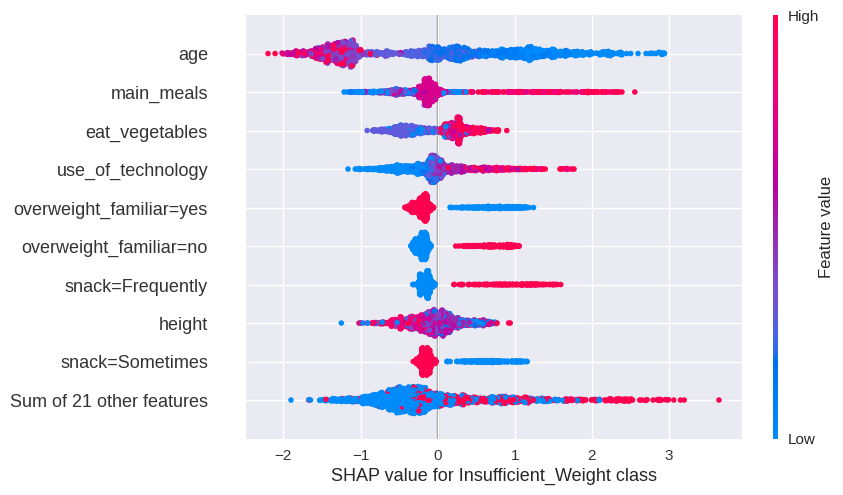

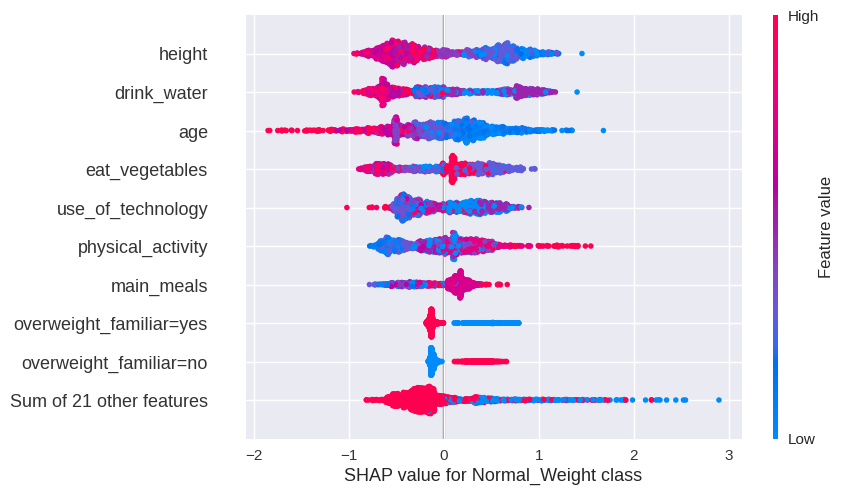

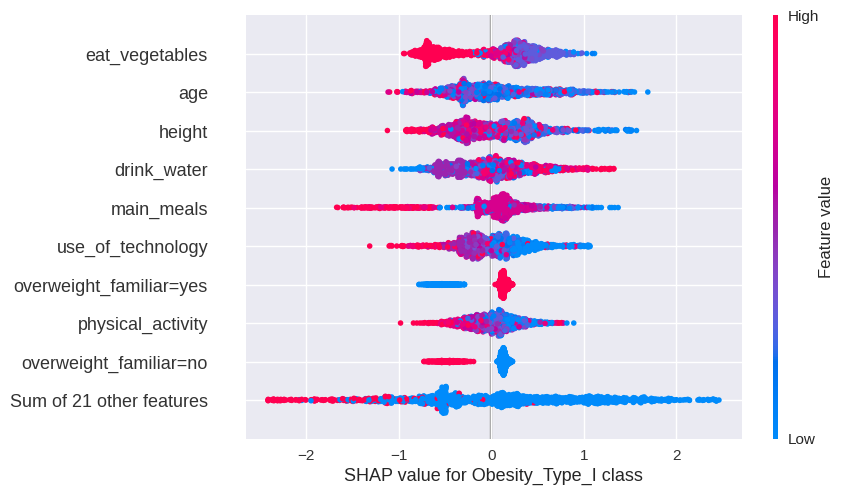

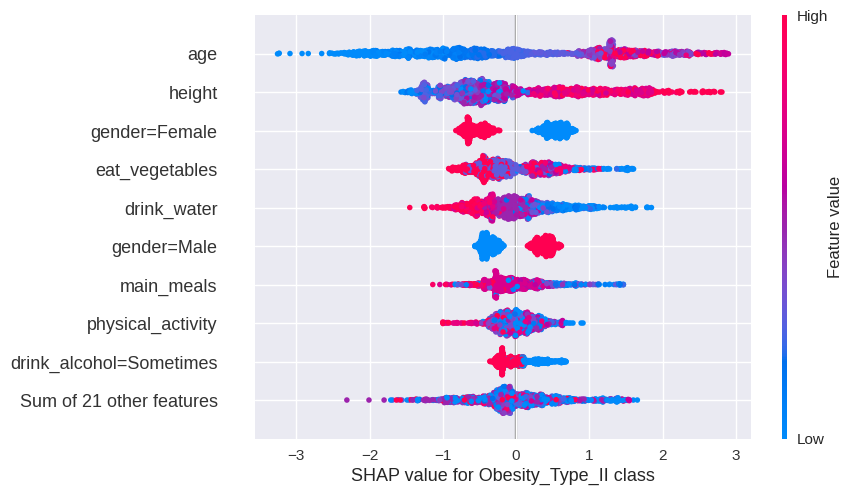

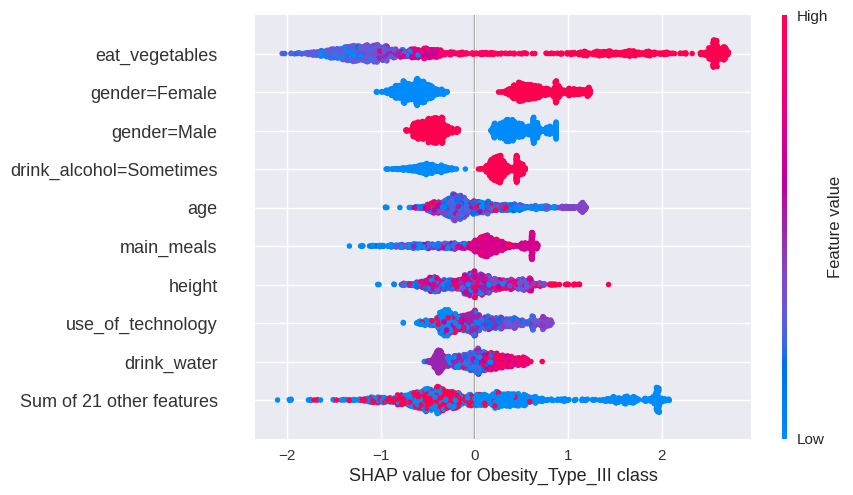

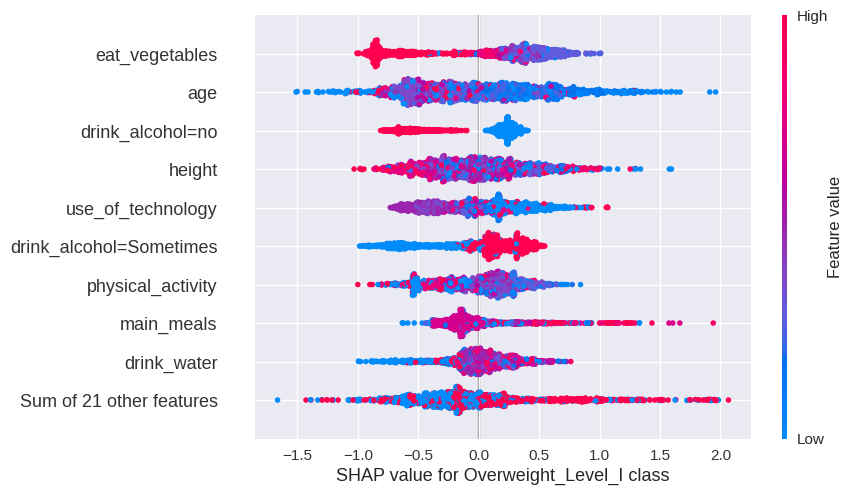

In [ ]:
plt.style.use("seaborn-v0_8")
for i in range(6):
    shap.plots.beeswarm(shap_values[..., i], show=False)
    plt.xlabel(f"SHAP value for {le.classes_[i]} class")
    plt.show()

According to the diagram presented above, when a point (an instance) is blue, it indicates that its original feature value in the dataset is low, whereas when a point is red, it indicates that the original feature value in the dataset is high.

With this clarified, four situations can arise:

+ Red point scattered towards negative SHAP values: For this instance, the feature indicates that the higher its value, the lower the prediction value, as it requires the SHAP value contribution to the prediction to be smaller.
+ Red point scattered towards positive SHAP values: On the contrary, for this instance, the feature indicates that the higher its value, the higher the prediction value, as it requires the SHAP value contribution to the prediction to be larger.
+ Blue point scattered towards negative SHAP values: For this instance, the feature indicates that the lower its value, the lower the prediction value, as it requires the SHAP value contribution to the prediction to be smaller.
+ Blue point scattered towards positive SHAP values: For this instance, the feature indicates that the lower its value, the higher the prediction value, as it requires the SHAP value contribution to the prediction to be larger.

In this way, we can conclude that, for example, for the Insufficient_Weight class, the individual's age, the higher it is, the less likely it is that this individual belongs to this class. On the other hand, it can be seen that for the Normal_Weight class, it is more likely that individuals who belong to this class have high physical activity.

## Saving the pipeline, the label encoder and the model with CloudPickle

An important difference between `cloudpickle` and `pickle` is that `cloudpickle` can serialize a function or class **by value**, whereas `pickle` can only serialize it **by reference**.

**Serialization by reference** treats functions and classes as attributes of modules, and pickles them through instructions that trigger the import of their module at load time. **Serialization by reference** is thus limited in that it assumes that the module containing the function or class is available/importable in the unpickling environment. This assumption breaks when pickling constructs defined in an interactive session, a case that is automatically detected by `cloudpickle`, that pickles such constructs **by value**.

In [ ]:
import cloudpickle

with open('obesity-levels-model.bin', 'wb') as f_out:
    cloudpickle.dump((pipe, le, cbc), f_out)

# Converting Notebook to PDF

In [1]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc nbconvert[webpdf]
!playwright install

from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')
clear_output(wait=False)

In [5]:
%%capture
!jupyter nbconvert --to webpdf /content/drive/MyDrive/ML_Zoomcamps_2024/Midterm_project/Estimation_of_obesity_levels_Midterm_project.ipynb